# Linear Regression, GRLR (Geodesic Regression Linear Residuals), GR on the sphere

In [1]:
import setcwd
setcwd.main()
from my28brains.regression.geodesic_regression import GeodesicRegression

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import torch

import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere, HypersphereMetric
from geomstats.learning.frechet_mean import FrechetMean, variance

torch_dtype = torch.float64

Working directory:  /home/adele/code/my28brains/my28brains
Directory added to path:  /home/adele/code/my28brains
Directory added to path:  /home/adele/code/my28brains/my28brains
Directory added to path:  /home/adele/code/my28brains/H2_SurfaceMatch


INFO: Using pytorch backend


In [40]:
def fit_linear_regression_sphere():  # , device = "cuda:0"):
    """Perform linear regression on parameterized meshes.

    Parameters
    ----------
    mesh_sequence_vertices: vertices of mesh sequence to be fit
    times: list of times corresponding to mesh_sequence_vertices

    Returns
    -------
    intercept_hat: intercept of regression fit
    coef_hat: slope of regression fit
    """
    gs.random.seed(0)
    
    #Create Data
    space = Hypersphere(dim=2)

    # Generate noise-free data
    n_samples = 50
    X = gs.random.rand(n_samples)
    X -= gs.mean(X)

    intercept = space.random_uniform()
    coef = space.to_tangent(
        5.0 * gs.random.rand(space.embedding_space.dim), base_point=intercept
    )
    y = space.metric.exp(X[:, None] * coef, base_point=intercept)

    # Generate normal noise
    normal_noise = gs.random.normal(size=(n_samples, space.embedding_space.dim))
    noise = space.to_tangent(normal_noise, base_point=y) / gs.pi / 2

    rss = gs.sum(space.metric.squared_norm(noise, base_point=y)) / n_samples

    # Add noise
    y = space.metric.exp(noise, y)

    #Linear Regression

    X_copy = gs.array(X.reshape(len(X), 1))
    lr = LinearRegression()

    lr.fit(X_copy, y)

    intercept_hat, coef_hat = gs.array(lr.intercept_), gs.array(lr.coef_)

    # Measure goodness of fit
    r2_hat = lr.score(X_copy, y)

    #Calculate MSE
    mse_intercept = gs.linalg.norm(intercept_hat - intercept) ** 2
    mse_coef = gs.linalg.norm(
        coef_hat - coef
    ) ** 2

    print(f"MSE on the intercept: {mse_intercept:.2e}")
    print(f"MSE on the coef, i.e. initial velocity: {mse_coef:.2e}")
    print(f"Determination coefficient: R^2={r2_hat:.2f}")
    # print(f"True R^2: {r2:.2f}")

    # Plot
    fitted_data = gs.array(lr.predict(X_copy))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    sphere_visu = visualization.Sphere(n_meridians=30)
    ax = sphere_visu.set_ax(ax=ax)

    # regressed_line = gs.array(
    #     coef_hat * t + intercept_hat for t in X
    # )
    
    size = 10
    marker = "o"
    sphere_visu.draw_points(ax, gs.array([intercept_hat]), marker=marker, c="r", s=size)
    sphere_visu.draw_points(ax, y, marker=marker, c="b", s=size)
    sphere_visu.draw_points(ax, fitted_data, marker=marker, c="g", s=size)

    # ax.plot(
    #     regressed_line[:, 0],
    #     regressed_line[:, 1],
    #     regressed_line[:, 2],
    #     c="gray",
    # )
    sphere_visu.draw(ax, linewidth=1)
    ax.grid(False)
    plt.axis("off")

    plt.show()

    return intercept_hat, coef_hat, lr


MSE on the intercept: 3.50e-01
MSE on the coef, i.e. initial velocity: 2.28e+01
Determination coefficient: R^2=0.56


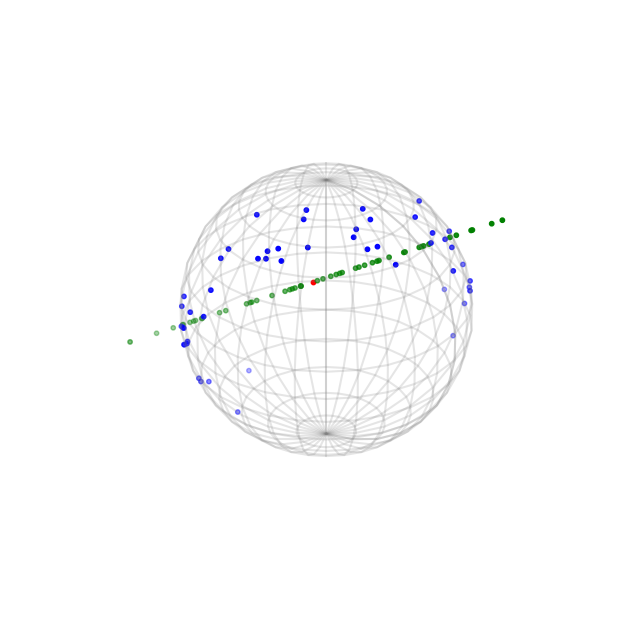

torch.Size([3])
torch.Size([3, 1])
torch.Size([3])


In [48]:
intercept_hat, coef_hat, _ = fit_linear_regression_sphere()

print(intercept_hat.shape)
print(coef_hat.shape)

coef_hat = coef_hat.reshape(intercept_hat.shape)
print(coef_hat.shape)

In [49]:
def fit_geodesic_regression_sphere(geodesic_residuals = True, intercept_hat_guess = None, coef_hat_guess = None):
    r"""Compute and visualize a geodesic regression on the sphere.

    The generative model of the data is:
    :math:`Z = Exp_{\beta_0}(\beta_1.X)` and :math:`Y = Exp_Z(\epsilon)`
    where:
    - :math:`Exp` denotes the Riemannian exponential,
    - :math:`\beta_0` is called the intercept,
    - :math:`\beta_1` is called the coefficient,
    - :math:`\epsilon \sim N(0, 1)` is a standard Gaussian noise,
    - :math:`X` is the input, :math:`Y` is the target.
    """
    gs.random.seed(0)
    
    space = Hypersphere(dim=2)
    # space.default_metric()

    # Generate noise-free data
    n_samples = 50
    X = gs.random.rand(n_samples)
    X -= gs.mean(X)

    intercept = space.random_uniform()
    coef = space.to_tangent(
        5.0 * gs.random.rand(space.embedding_space.dim), base_point=intercept
    )
    y = space.metric.exp(X[:, None] * coef, base_point=intercept)

    # Generate normal noise
    normal_noise = gs.random.normal(size=(n_samples, space.embedding_space.dim))
    noise = space.to_tangent(normal_noise, base_point=y) / gs.pi / 2

    rss = gs.sum(space.metric.squared_norm(noise, base_point=y)) / n_samples

    # Add noise
    y = space.metric.exp(noise, y)

    # True noise level and R2
    estimator = FrechetMean(space.metric)
    estimator.fit(y)
    # variance_ = variance(space, y, estimator.estimate_)
    variance_ = variance(y, estimator.estimate_, space.metric)
    r2 = 1 - rss / variance_

    # Fit geodesic regression
    gr = GeodesicRegression(
        space, 
        metric = space.metric,
        #center_X=False, 
        method="extrinsic", 
        initialization = 'warm_start', 
        geodesic_residuals=geodesic_residuals
    )

    if intercept_hat_guess is None:
        intercept_hat_guess = gs.array(y[0])
    elif intercept_hat_guess.shape != y[0].shape:
        raise ValueError(
            "intercept_hat_guess must be None or have mesh_sequence[0].shape"
        )

    if coef_hat_guess is None:
        coef_hat_guess = gs.array(
            y[1] - y[0]
        )

    gr.intercept_ = intercept_hat_guess
    gr.coef_ = coef_hat_guess

    gr.fit(gs.array(X), gs.array(y), compute_training_score=False)
    intercept_hat, coef_hat = gr.intercept_, gr.coef_

    # # Measure Mean Squared Error
    mse_intercept = space.metric.squared_dist(intercept_hat, intercept)

    tangent_vec_to_transport = coef_hat
    tangent_vec_of_transport = space.metric.log(intercept, base_point=intercept_hat)
    transported_coef_hat = space.metric.parallel_transport(
        tangent_vec=tangent_vec_to_transport,
        base_point=intercept_hat,
        direction=tangent_vec_of_transport,
    )
    mse_coef = space.metric.squared_norm(
        transported_coef_hat - coef, base_point=intercept
    )

    # Measure goodness of fit
    r2_hat = gr.training_score_

    # print(f"MSE on the intercept: {mse_intercept:.2e}")
    # print(f"MSE on the coef, i.e. initial velocity: {mse_coef:.2e}")
    # print(f"Determination coefficient: R^2={r2_hat:.2f}")
    # print(f"True R^2: {r2:.2f}")

    # Plot
    fitted_data = gr.predict(X)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    sphere_visu = visualization.Sphere(n_meridians=30)
    ax = sphere_visu.set_ax(ax=ax)

    path = space.metric.geodesic(
        initial_point=intercept_hat, initial_tangent_vec=coef_hat
    )
    regressed_geodesic = path(
        gs.linspace(0.0, 1.0, 100) * gs.pi * 2 / space.metric.norm(coef)
    )
    regressed_geodesic = gs.to_numpy(regressed_geodesic)

    size = 10
    marker = "o"
    sphere_visu.draw_points(ax, gs.array([intercept_hat]), marker=marker, c="r", s=size)
    sphere_visu.draw_points(ax, y, marker=marker, c="b", s=size)
    sphere_visu.draw_points(ax, fitted_data, marker=marker, c="g", s=size)

    ax.plot(
        regressed_geodesic[:, 0],
        regressed_geodesic[:, 1],
        regressed_geodesic[:, 2],
        c="gray",
    )
    sphere_visu.draw(ax, linewidth=1)
    ax.grid(False)
    plt.axis("off")

    plt.show()

torch.Size([3])
tensor([2.1200, 1.5609, 0.8176])
torch.Size([3])
torch.Size([3])


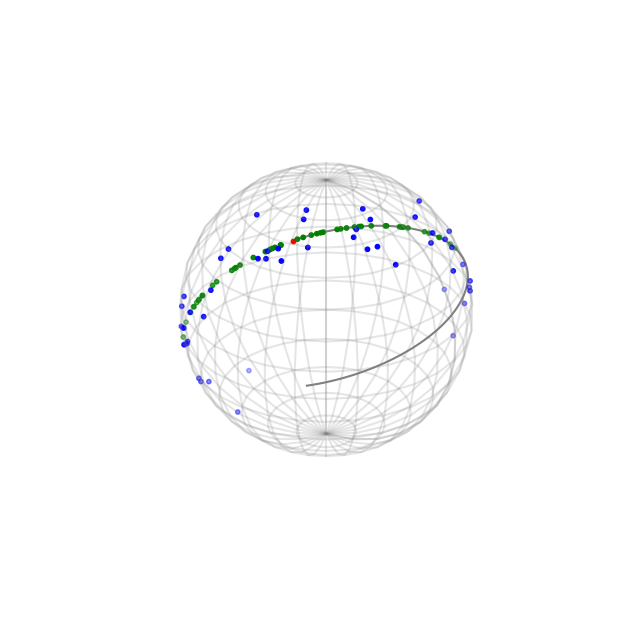

In [50]:
fit_geodesic_regression_sphere(geodesic_residuals = True, #intercept_hat_guess = None, coef_hat_guess = None) 
intercept_hat_guess = intercept_hat, coef_hat_guess = coef_hat)

torch.Size([3])
tensor([ 0.0471, -0.5983,  0.7761])
torch.Size([3])
torch.Size([3])


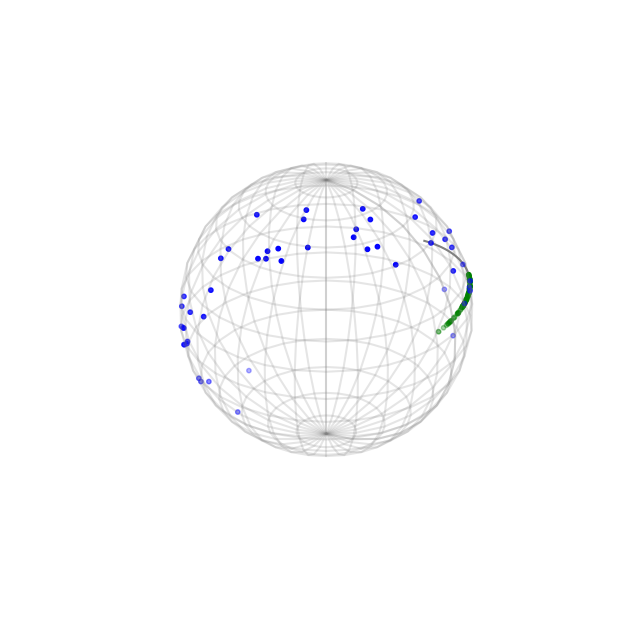

In [51]:
fit_geodesic_regression_sphere(geodesic_residuals = False, intercept_hat_guess = None, coef_hat_guess = None) #intercept_hat_guess = intercept_hat, coef_hat_guess = coef_hat)